In [1]:

from config.args import get_arguments
from config.config import features,labels,duplex_labels,train_test_ratio,label_extension,threshold, train_val_ratio, random
from dataloader.load_data import SimplexDataset, DuplexDataset, InputSimplexDataset, InputDuplexDataset, load_dataloader
from utils.load_json import load_results
from utils.save_load_model import load
from utils.convert import convertBinary
from utils.metrics import binary_iou
from utils.output_viz import print_output
from model.UNet import UNet, CustomUNet
from model.ENet import ENet
from model.DeepLabV3 import CustomDeepLabV3
from train.train import Train
from train.test import Test

from tqdm import tqdm
import logging
import os
import torch
import json
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import random_split, DataLoader

In [2]:
def train(model,dataset):
    if random:
        train_set, test_set = random_split(dataset,train_test_ratio,torch.Generator())
    else:
        train_size = len(dataset)*train_test_ratio[0]
        train_set = Subset(dataset,range(int(train_size)))
        test_set = Subset(dataset,range(int(train_size),len(dataset)))
    filepath = os.path.join(args.save_folder,f'''{args.model}-{args.dataset}.pt''')
    if os.path.exists(filepath):
        model = load(model,args)
    train = Train(model,device,train_set,args)
    train.run()
    
    model = load(model,args)
    test = Test(model,device,test_set,int(args.batch))
    test.run()
    
    train.save_plot()

def test(model,dataset):
    model = load(model,args)
    test = Test(model,device,dataset,int(args.batch))
    test.run()

def inference(model):
    if not os.path.exists(args.output_folder):
        os.mkdir(args.output_folder)
    model.eval()
    model.to(device)
    if args.dataset == "simplex":
        data = InputSimplexDataset(args)
    elif args.dataset == "duplex":
        data = InputDuplexDataset(args)
    loader = DataLoader(data,batch_size = int(args.batch))
    
    json_name = ""
    intermediate = []
    for batch in loader:
        input = batch[2].to(device)
        outputs = model(input.float())
        outputs = convertBinary(outputs)
        for name,pn,output in zip(batch[0],batch[1],outputs):
            if not json_name:
                json_name = name
            if json_name != name:
                fp = open(os.path.join(args.output_folder,json_name,"results.json"),"w")
                json.dump({"intermediate_results":intermediate},fp)
                fp.close()
                json_name = name
                intermediate = []
            pn = pn.item()
            pgnum = (4-len(str(pn)))*"0" + str(pn)
            json_instance = {"pdf_filename":name+".pdf","page_num":pn,"intermediate_dir":"intermediate_results/"+pgnum}
            path = os.path.join(args.output_folder,name)
            if not os.path.exists(path):
                os.mkdir(path)
            path = os.path.join(path,"intermediate_results")
            if not os.path.exists(path):
                os.mkdir(path)
            if args.dataset == "simplex":
                path = os.path.join(path,pgnum)
                if not os.path.exists(path):
                    os.mkdir(path)
                for i, label in enumerate(labels):
                    to_pil_image(output[i]).save(os.path.join(path,f'''{label}{label_extension}'''))
                    json_instance[label] = json_instance["intermediate_dir"]+"/"+str(label)+str(label_extension)
                intermediate.append(json_instance)
            
            elif args.dataset == "duplex":
                pgnum2 = (4-len(str(pn)))*"0" + str(pn+1)
                json_instance2 = {"pdf_filename":name+".pdf","page_num":pn+1,"intermediate_dir":"intermediate_results/"+pgnum2}
                path2 = os.path.join(path,pgnum2)
                path = os.path.join(path,pgnum)
                if not os.path.exists(path):
                    os.mkdir(path)
                if not os.path.exists(path2):
                    os.mkdir(path2)
                cur = 0
                for i, label in enumerate(labels):
                    to_pil_image(output[cur + i]).save(os.path.join(path,f'''{label}{label_extension}'''))
                    json_instance[label] = json_instance["intermediate_dir"]+"/"+str(label)+str(label_extension)
                cur += len(labels)
                for i, label in enumerate(duplex_labels):
                    to_pil_image(output[cur + i]).save(os.path.join(path,f'''{label}{label_extension}'''))
                    json_instance[label] = json_instance["intermediate_dir"]+"/"+str(label)+str(label_extension)
                cur += len(duplex_labels)
                for i, label in enumerate(labels):
                    to_pil_image(output[cur + i]).save(os.path.join(path2,f'''{label}{label_extension}'''))
                    json_instance2[label] = json_instance2["intermediate_dir"]+"/"+str(label)+str(label_extension)
                intermediate.append(json_instance)
                intermediate.append(json_instance2)

In [3]:
class default:
    def __init__(self):
        self.input_folder = "./data/cache/DP_a2200_xml_ff2c81d8ad6655f915cbaa558ee7bf9e878730a8"
        self.output_folder = "./output"
        self.label_folder = "./data/output/DP_a2200_xml_ff2c81d8ad6655f915cbaa558ee7bf9e878730a8"
        self.save_folder = "./checkpoints"
        self.model = "unet"
        self.mode = "train"
        self.epoch = 300
        self.lr = 1e-5
        self.lr_decay = 0.1
        self.lr_epoch = 50
        self.batch = 5
        self.dataset = "simplex"
        
class WeightedBinaryLoss(torch.nn.Module):
    
    def __init__(self, w_p = None, w_n = None):
        super(WeightedBinaryLoss, self).__init__()
        self.w_p = w_p
        self.w_n = w_n
        
    def forward(self, inputs, labels, epsilon = 1e-7):
        loss_pos = -1 * torch.mean(self.w_p * labels * torch.log(inputs + epsilon))
        loss_neg = -1 * torch.mean(self.w_n * (1-labels) * torch.log((1-inputs) + epsilon))
        loss = loss_pos + loss_neg
        return loss
        
args = default()
criterion = WeightedBinaryLoss(w_p = 2.0,w_n = 2.0)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logging.info(f'''Using device: {device}''')

n_input = len(features) if args.dataset == 'simplex' else 2*len(features)
n_output = len(labels) if args.dataset == 'simplex' else 2*len(labels)+len(duplex_labels)
if args.mode != 'inference':
    pdf,algorithm,intermediate = load_results(args.label_folder)
    if args.dataset =='simplex':
        dataset = SimplexDataset(args.input_folder,args.label_folder,intermediate)
    else:
        dataset = DuplexDataset(args.input_folder,args.label_folder,intermediate)
        
if args.model == 'unet':
    model = CustomUNet(n_input,n_output)
elif args.model == 'enet':
    model = ENet(n_input,n_output)
elif args.model == 'deeplabv3':
    model = CustomDeepLabV3(n_output)
    


INFO: Using device: cuda
INFO: Preparing SimplexDataset...
INFO: Finished preparing SimplexDataset
INFO: Total 5093 samples
INFO: Initializing UNet Model...
INFO: Done initialize UNet Model


INFO: Initializing training script...
INFO: Preparing Dataloader...
INFO: Done preparing Dataloader
INFO: Done initialize training script
100%|██████████| 917/917 [02:50<00:00,  5.39it/s]


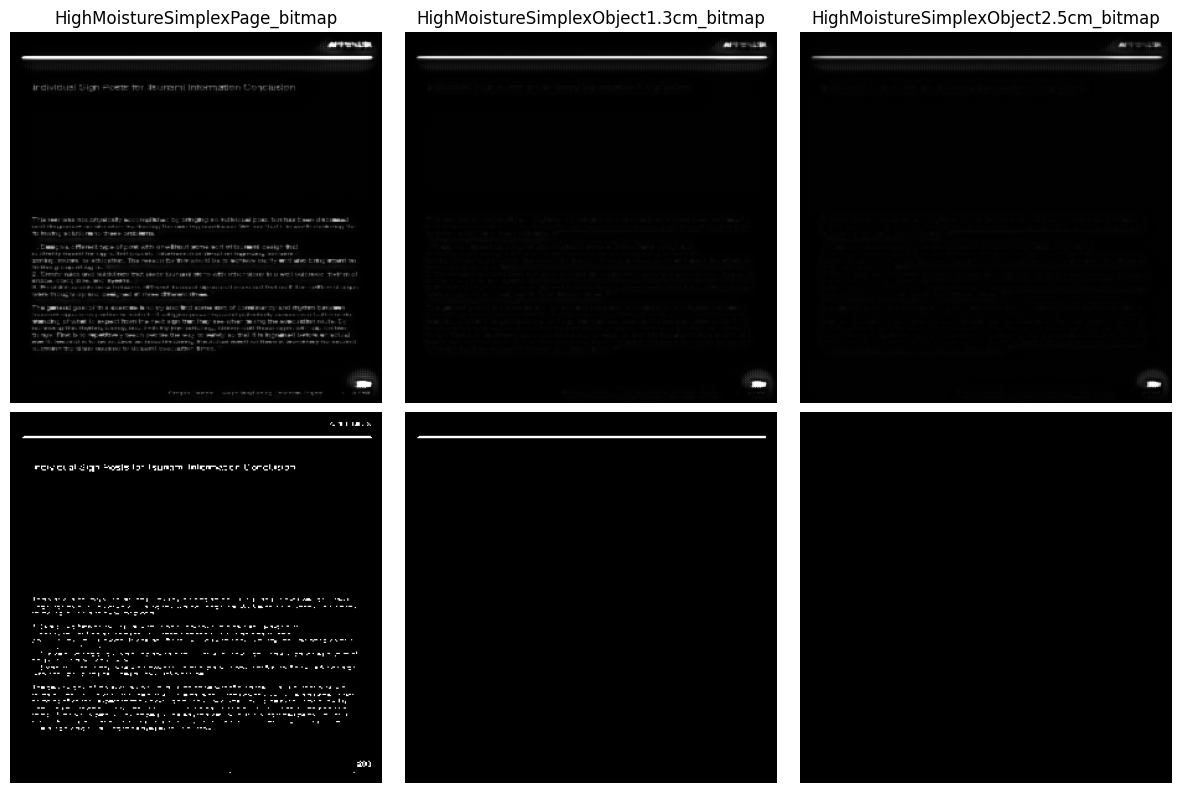

100%|██████████| 101/101 [00:34<00:00,  2.89it/s]
INFO: Epoch [0/300], Loss: 0.1108, Val Loss: 0.0512, Train IoU: 64.36%, IoU: 68.10%


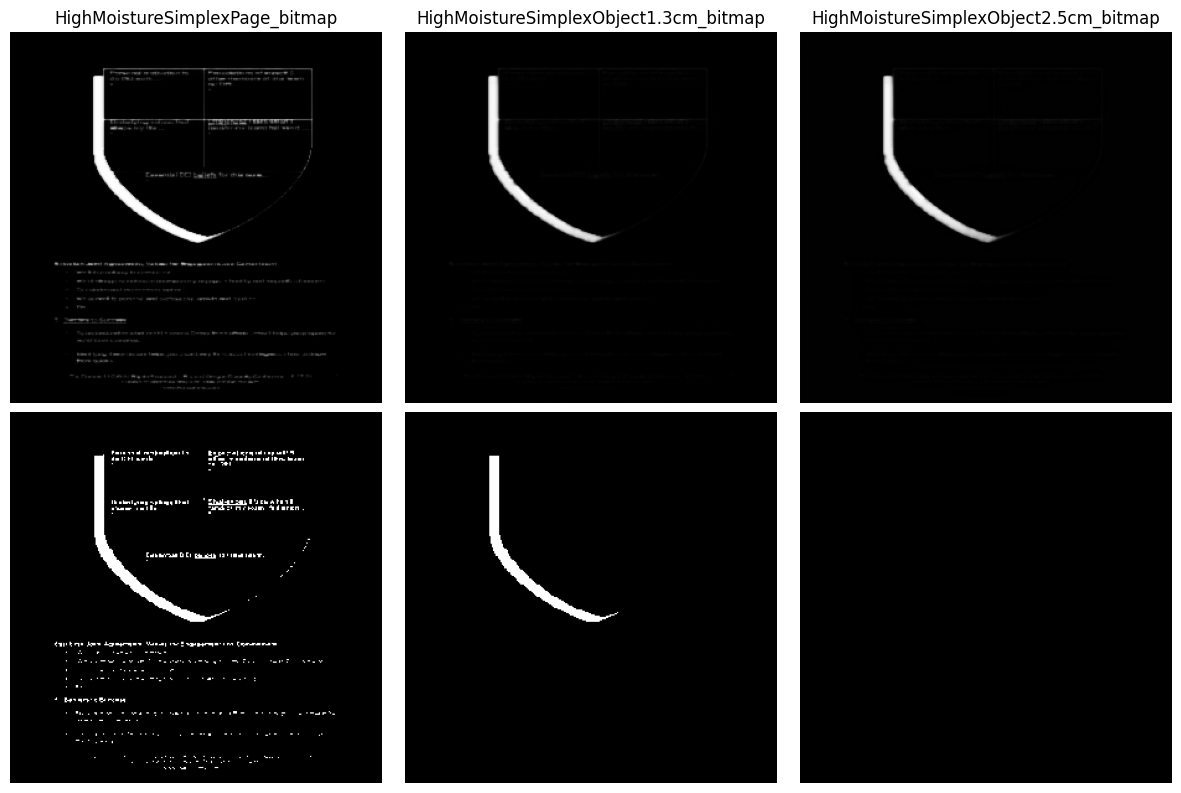

100%|██████████| 917/917 [02:42<00:00,  5.64it/s]


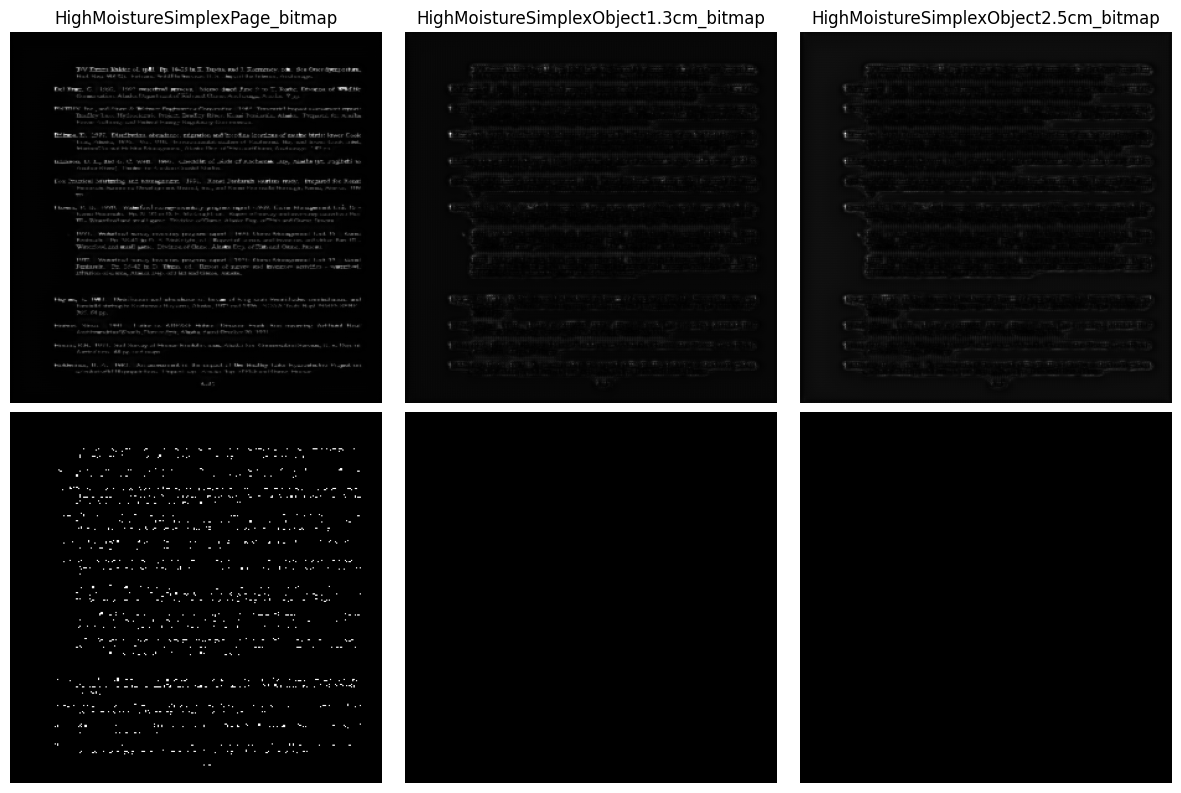

100%|██████████| 101/101 [00:34<00:00,  2.95it/s]
INFO: Epoch [1/300], Loss: 0.0450, Val Loss: 0.0396, Train IoU: 68.85%, IoU: 70.66%


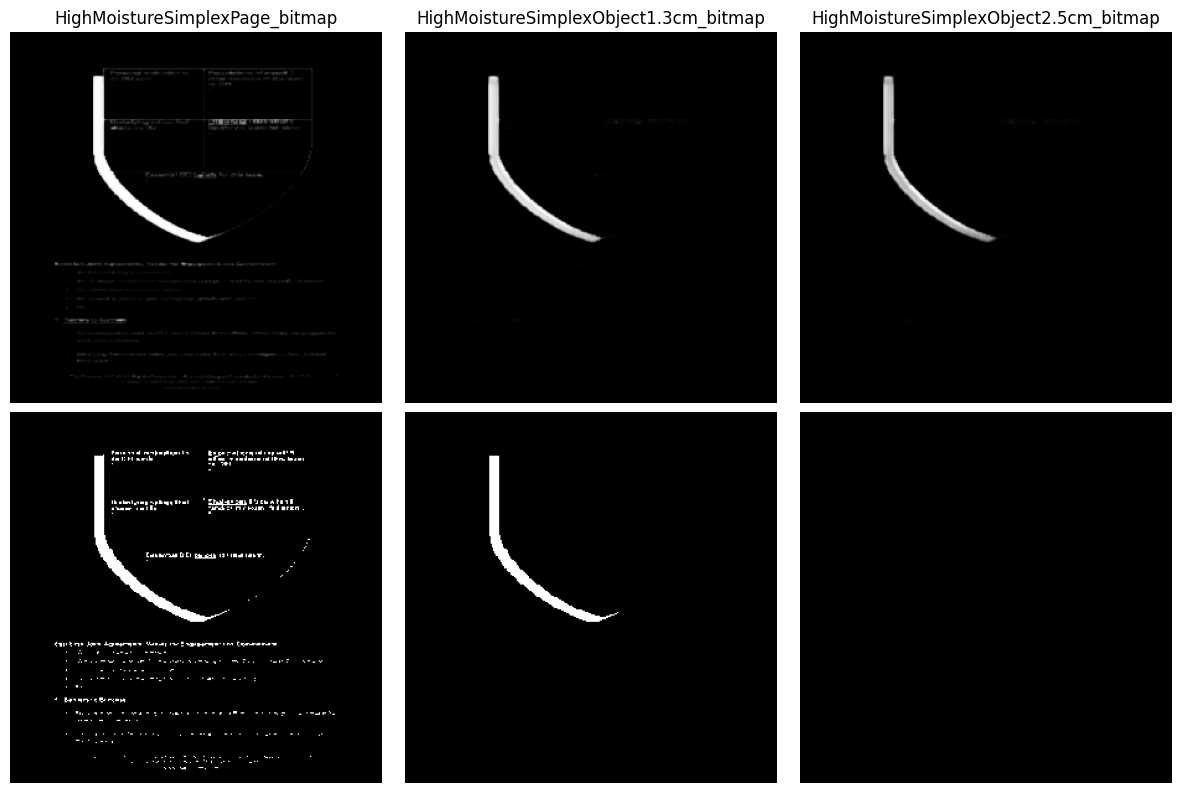

  0%|          | 0/917 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [5]:

args.lr=5e-4
train = Train(model,device,dataset,args)
# train = Train(model,device,dataset,args,criterion=criterion)
train.model.to(device)

for i in range(args.epoch):
    epoch_loss = 0.0
    IoU = 0.0
    label_IoU = 0.0
    train.model.train()
    for batch_data in tqdm(train.train_dataloader):
        train.optim.zero_grad()
        inputs, labels = batch_data[0].to(train.device), batch_data[1].to(train.device)
        preds = train.model(inputs.float())
        loss = train.criterion(preds,labels)
        loss.backward()
        train.optim.step()
        epoch_loss += loss.item()
        IoU += binary_iou(convertBinary(preds),labels)
    label_IoU /= len(train.train_dataloader)
    train.train_IoU.append(IoU / len(train.train_dataloader))
    train.epoch_losses.append(epoch_loss / len(train.train_dataloader))
    print_output(0,preds,labels)
    train.model.eval()
    epoch_loss = 0.0
    IoU = 0.0
    for batch_data in tqdm(train.val_dataloader):
        inputs, labels = batch_data[0].to(train.device), batch_data[1].to(train.device)
        preds = train.model(inputs.float())
        loss = train.criterion(preds,labels)
        epoch_loss += loss.item()
        IoU += binary_iou(convertBinary(preds),labels)
    train.IoU.append(IoU / len(train.val_dataloader))
    train.epoch_losses_val.append(epoch_loss / len(train.val_dataloader))
    logging.info(f'''Epoch [{i}/{args.epoch}], Loss: {train.epoch_losses[-1]:.4f}, Val Loss: {train.epoch_losses_val[-1]:.4f}, Train IoU: {train.train_IoU[-1] * 100:.2f}%, IoU: {train.IoU[-1] * 100:.2f}%''')
    print_output(0,preds,labels)